# Reinforcement Learning of the game 2048

This notebooks contains a summary of the best working models and allows you to visualize them. Also, you can use it to train your own agent

### 0 Imports

You can autorun the notebook and autstop after the imports

In [1]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib.cm as cm
import ipywidgets as widgets
from ipyevents import Event
import time
import gymnasium as gym
import torch
import torch.nn as nn
from typing import Any, cast
from collections import deque
import random
import cv2
from IPython.display import HTML
from matplotlib.patches import FancyArrow
import pickle

In [2]:
sys.path.insert(1, str(Path("../..")))
from andreas2048.game import *
from andreas2048 import gym2048
env = gym2048.Env2048()

In [3]:
# Trick to let "Run all" stop after the imports
raise RuntimeError("STOP")

RuntimeError: STOP

### 1 Interactive game

This cell allows you to play an interactive game using the arrow keys. By pressing z you can undo your move and by pressing 

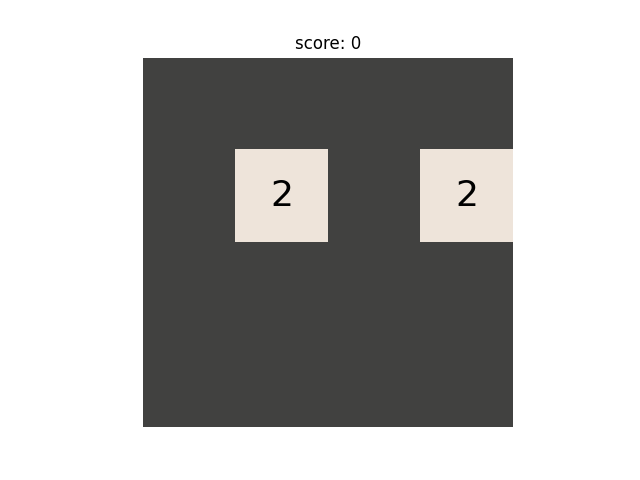

In [ ]:
%matplotlib widget

game = Game(shape=(4,4))
# Uncomment the following cell to try a warm start
#game.state.warm_start(tiles=[1,2,3,4,5,6,7,8,9,10,11,12], p=[20,10,5,5,4,3,1,1,1,1,1,1], n=3)

plot_arrows = False

def on_press(e):
    global plot_arrows, stdout
    if not game.alive:
        return
    match e.key:
        case "left":
            r = game.next(Action.LEFT)
        case "right":
            r = game.next(Action.RIGHT)
        case "up":
            r = game.next(Action.UP)
        case "down":
            r = game.next(Action.DOWN)
        case "r":
            plot_arrows = not plot_arrows
        case "z":
            game.undo()
        case _:
            r = False
    game.plot_on_axis(ax, plot_arrows=plot_arrows)
    ax.set_title(ax.get_title() + f"\nEstimated score: {game.state.estimate_score()}")
    fig.canvas.draw()

fig, ax = plt.subplots()
fig.canvas.mpl_connect('key_press_event', on_press)
game.plot_on_axis(ax)
plt.show()

In [ ]:
# Important: Run this cell once you are done with the interactive play
%matplotlib inline

Visualize the game and the states

In [ ]:
print(game)
print(game.state)
print(len(game.history))
print("History 1-10")
for s in game.history[:10]:
    print(s)

<2048 Game: score: 92 - moves: 18 - highest tile: 16>
[[ 0  0  0  2]
 [ 2  0  0  2]
 [ 0  0  2 16]
 [ 0  0 16  4]]
<2048 Game State n=18: score: 92 - highest tile 16 >
[[ 0  0  0  2]
 [ 2  0  0  2]
 [ 0  0  2 16]
 [ 0  0 16  4]]
19
History 1-10
<2048 Game State n=0: score: 0 - highest tile 2 >
[[0 0 0 0]
 [0 2 0 2]
 [0 0 0 0]
 [0 0 0 0]]
<2048 Game State n=1: score: 4 - highest tile 4 >
[[2 0 0 0]
 [0 0 0 4]
 [0 0 0 0]
 [0 0 0 0]]
<2048 Game State n=2: score: 4 - highest tile 4 >
[[2 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [2 0 0 4]]
<2048 Game State n=3: score: 4 - highest tile 4 >
[[0 2 0 2]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 2 4]]
<2048 Game State n=4: score: 4 - highest tile 4 >
[[0 0 0 0]
 [0 0 0 0]
 [0 0 2 2]
 [0 2 2 4]]
<2048 Game State n=5: score: 12 - highest tile 4 >
[[0 0 0 0]
 [0 2 0 0]
 [0 0 0 4]
 [0 0 4 4]]
<2048 Game State n=6: score: 20 - highest tile 8 >
[[0 0 0 2]
 [0 0 0 0]
 [0 0 0 0]
 [0 2 4 8]]
<2048 Game State n=7: score: 20 - highest tile 8 >
[[0 0 0 0]
 [0 0 0 0]
 [0 2 0 2]
 [0 

Play thousand games with random moves

In [5]:
%matplotlib inline
def stats(n: int, policy: Callable[[State], Action]):
    """ Play n games given a policy """
    t0 = time.perf_counter()
    history: list[Game] = []
    for i in range(n):
        env.reset()
        while env.game.alive:
            action = policy(env.game.state)
            env.step(action)
        history.append(env.game)
    t1 = time.perf_counter()
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    axes[0].hist([np.log2(g.highest_tile) for g in history])
    axes[0].set_title(f"Highest tile")
    axes[0].set_xlabel("Highest tile")
    axes[0].set_ylabel("Count")
    axes[0].set_xticks(range(4,13), [str(2**n) for n in range(4,13)])

    axes[1].hist([g.score for g in history])
    axes[1].set_title(f"Score")
    axes[1].set_xlabel("Score")
    axes[1].set_ylabel("Count")

    fig.suptitle(f"Played {n} games ({(t1-t0):1.3f}s per game)")

    plt.show()



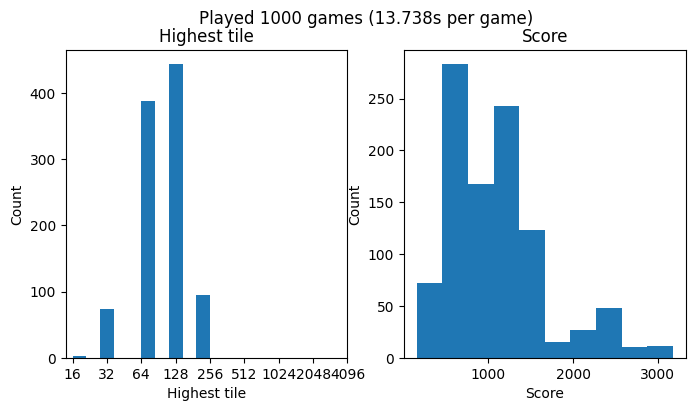

In [6]:
stats(1000, lambda s: random.sample(s.get_moves(), k=1)[0])

Plot the game

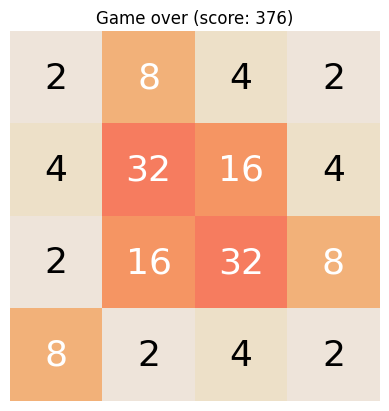

In [ ]:
%matplotlib inline
env.game.plot_on_axis(plt.gca())
plt.show()

### 2 Function approximator and agent

This cell contains the final, best working StateEstimator and Agent. 

In [7]:
class StateEstimator(nn.Module):
    """ 
        Implementation of State Aproximator for a 2048 grid.
    """

    def __init__(self, grid_shape: tuple[int, int], device: str) -> None:
        super().__init__()
        self.device = device
        assert grid_shape == (4,4)
        self.n_features = 7
        self.powers = torch.tensor([18**3, 18**2, 18, 1]).view(1,1,1,4).to(self.device)

        self.ttables = nn.Embedding(num_embeddings=18**4, embedding_dim=4*self.n_features).to(self.device)
        with torch.no_grad():
            self.ttables.weight.fill_(20_000.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Forward pass on the network. Expects tensor of shape (n,|n_features|,rotations,tuple values) """
        x = (x[:, :, :, :] * self.powers).sum(dim=-1) # (n,|n_features|,4,4) -> (n,|n_features|,4)
        x = self.ttables.forward(x) # (n,|n_features|,4) -> (n,|n_features|,4,4*|n_features|)
        x = x.flatten(start_dim=1, end_dim=-2) # (n,|n_features|,4,4*|n_features|) -> (n, 4*|n_features|, 4*|n_features|)
        x = x.diagonal(dim1=-2, dim2=-1).reshape(-1, self.n_features, 4) # (n,4*|n_features|,4*|n_features|) -> # (n, 4*|n_features|) -> (n,|n_features|,4)
        return x # (n,|n_features|,4)
    
    def count_unvisited_states(self, x: np.ndarray) -> int:
        """ This function counts the unvisited states in the input x by comparing the table values with their initial value """
        while len(x.shape) < 3: # (4,4) -> (1,4,4)
            x = x[None, ...]
        x = self.extract_tuples(x) # (n,4,4) -> (n,|n_features|,4,4)
        t = torch.from_numpy(x).to(self.device)
        vs = self.forward(t)
        return int(torch.count_nonzero(vs == self.ttables.weight[18**4-1][0]).item())
    
    def V_raw(self, x: np.ndarray) -> torch.Tensor:
        """ 
        Outputs the value function estimation by the model as a tensor with gradient

        Args:
            x (np.ndarray): n-boards of shape (n,4,4) 

        Returns:
            V (torch.Tensor): The value of the n-boards encoded as torch tensor with shape (n,)
        
        """
        while len(x.shape) < 3: # (4,4) -> (1,4,4)
            x = x[None, ...]
        x = self.extract_tuples(x) # (n,4,4) -> (n,|n_features|,4,4)
        t = torch.from_numpy(x).to(self.device)
        vs = torch.mean(self.forward(t), dim=(1,2)) 
        return vs

    def V(self, x: np.ndarray) -> np.ndarray:
        """ 
        Outputs the value function estimation by the model as numpy array without gradient.

        Args:
            x (np.ndarray): n-boards of shape (n,4,4) 

        Returns:
            V (np.ndarray): The value of the n-boards encoded as numpy array with shape (n,)
        
        """
        while len(x.shape) < 3: # (4,4) -> (1,4,4)
            x = x[None, ...]
        x = self.extract_tuples(x) # (n,4,4) -> (n,|n_features|,4,4)
        t = torch.from_numpy(x).to(self.device)
        with torch.no_grad():
            vs = torch.mean(self.forward(t), dim=(1,2)) 
        return vs.detach().numpy()
    

    def extract_tuples(self, grid: np.ndarray) -> np.ndarray:
        """
        Extract the n-tuples from n boards of shape (n, 4, 4). Returns the tuples as a numpy array of shape \n
        (n, |n_tuple|, 4, 4) = (n, 14, 4, 4) \n
        with the third value representing the rotation (Top, Right, Bottom, Left) and the last values the ith 
        value inside the n-tuple.
        """
        assert len(grid.shape) >= 3 and grid.shape[1] == 4 and grid.shape[2] == 4
        n_tuples = np.zeros(shape=(grid.shape[0],self.n_features,4,4), dtype=grid.dtype)
        for k in range(4):
            g_v = np.rot90(grid, k=k, axes=(1,2))
            n_tuples[:,0,k] = g_v[:,0,::-1] # Outer
            n_tuples[:,1,k] = g_v[:,1,:: 1] # Inner
            n_tuples[:,2,k] = g_v[:, [1,1,0,0], [-2,-1,-1,-2]] # Edge
            n_tuples[:,3,k] = g_v[:, [1,1,0,0], [-3,-2,-2,-3]] # Inner Edge
            # n_tuples[:,4,k] = g_v[:, [2,1,1,0], [0,0,1,1]] # Left Z
            # n_tuples[:,5,k] = g_v[:, [2,1,1,0], [1,1,2,2]] # Middle Z
            # n_tuples[:,6,k] = g_v[:, [2,1,1,0], [2,2,3,3]] # Right Z
            # n_tuples[:,7,k] = g_v[:, [2,1,1,0], [1,1,0,0]] # Left Mirror Z
            # n_tuples[:,8,k] = g_v[:, [2,1,1,0], [2,2,1,1]] # Middle Mirror Z
            # n_tuples[:,9,k] = g_v[:, [2,1,1,0], [3,3,2,2]] # Right Mirror Z
            # n_tuples[:,10,k] = g_v[:, [2,1,0,0], [1,1,1,0]] # Left Arrow
            # n_tuples[:,11,k] = g_v[:, [2,1,0,0], [2,2,2,1]] # Middle Arrow
            # n_tuples[:,12,k] = g_v[:, [2,1,0,0], [3,3,3,2]] # Right Arrow
            # n_tuples[:,13,k] = g_v[:, [1,0,0,0], [2,2,1,0]] # Edge Arrow

        return n_tuples
    
# Testing the implementation
net = StateEstimator(grid_shape=env.game.shape, device="cpu")
print("Shape of extracted tuple (expect (n,n_features,4,4)):",net.extract_tuples(env.game.grid[None, :]).shape)
print("Full network output (expect a, a, b):", net.V(np.array([env.game.grid, env.game.grid, np.rot90(env.game.grid)])))
print("Unvisited states count:", net.count_unvisited_states(np.array([env.game.grid, env.game.grid])))

Shape of extracted tuple (expect (n,n_features,4,4)): (1, 7, 4, 4)
Full network output (expect a, a, b): [20000. 20000. 20000.]
Unvisited states count: 56


In [8]:
class Agent:
    """ Implements an agent for 2048 """
    
    def __init__( self,
                env: gym2048.Env2048, 
                learning_rate: float = 0.05, 
                gamma: float = 0.99,
                epsilon: float = 1.0,
                epsilon_decay = 0.005,
                epsilon_min = 0.001,
               ) -> None:
        self.env = env
        self.env.reset()
        self.device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Learning parameters
        self._lr = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.warm_start_tiles = [1,2,3,4,5,6,7,8,9,10,11,12]
        self.warm_start_p = [20,10,5,5,4,3,1,1,1,1,1,1]
        self.warm_start_n = 3

        self.episode = 0
        self.batch_size: int = 500
        self.history: list[Game] = []
        self.losses: dict[int, float] = {}
        self.V_ranges: dict[int, tuple[tuple[float, float], tuple[float, float]]] = {}
        self.unvisited_states_count: dict[int, float] = {}
        self.init()

    def init(self):
        self.model = StateEstimator(grid_shape=env.game.grid.shape, device=self.device)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self._lr)
        self.replay_buffer: deque[tuple[State, float]] = deque(maxlen=2_000)

        self.qv_without_rewards: bool = False
        self.backtrace_lambda: bool = False
        self.td_lambda: bool = False
        self.lambda_: float = 0.99 # In case of backtracing transform reward to discounted return Gt with half time t=60
        self.update_method: Literal["MC", "TD"] = "TD"

    def remember(self) -> None:
        """ Add the current game in the game history to the replay buffer and history list """
        if self.backtrace_lambda:
            for s in self.env.game.history:
                if s.parent is not None:
                    s.parent.backtrace_reward(s.reward, lambda_=self.lambda_, adjust=self.td_lambda) 
        self.replay_buffer.extend([(s, s.reward) for s in self.env.game.history[1:]]) 
        self.history.append(env.game)

    def reset(self, warm_start: bool = False) -> None:
        """ Resets the environment"""
        self.env.reset()
        if warm_start:
            self.env.game.state.warm_start(tiles=self.warm_start_tiles, p=self.warm_start_p, n=self.warm_start_n)

    def update(self) -> None:
        """ Updates the model using the replay buffer """
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = random.choices(self.replay_buffer, k=self.batch_size)
        states, reward = cast(tuple[list[State], list[float]], zip(*batch))

        grids = np.array([s.parent.grid for s in states]) # s_n
        next_grid = np.array([s.grid for s in states]) # s_n+1
        rewards = np.array([r for r in reward]) # (Discounted) reward from s_n to s_n+1
        rewards = torch.from_numpy(rewards).float().to(self.device)

        vn_estimated = self.model.V_raw(grids)
        with torch.no_grad():
            if self.update_method == "MC":
                vn_actually = rewards
            elif self.update_method == "TD":
                vn_actually = rewards + self.gamma*(self.model.V_raw(next_grid))

        v1 = vn_estimated.detach().numpy()
        v2 = vn_actually.detach().numpy()
        self.V_ranges[self.episode] = ((np.min(v1), np.max(v1)), (np.min(v2), np.max(v2)))
        self.unvisited_states_count[self.episode] = self.model.count_unvisited_states(grids)

        loss: torch.Tensor = nn.L1Loss()(vn_estimated, vn_actually)
        self.losses[self.episode] = float(loss.detach().numpy())
        self.optimizer.zero_grad()
        loss.backward()
        self.model.ttables.weight.grad *= loss*len(states) # Boosting the gradient on the tables
        self.optimizer.step()

    def step(self) -> bool:   
        """ Perform the best action with an epsilon-greedy policy """
        next_state, reward, done, truncated, info = env.step(self.predict(greedy=False))
        return not(done or truncated)
    
    def predict(self, greedy: bool = True) -> Action:
        """ Predict the best action. If greedy = False, with probability epsilon a random action is returned """
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        if not greedy and np.random.rand() < self.epsilon:
            return self.env.action_space.sample(mask=mask)
        actions = self.get_qv(state=self.env.game.state, depth=0, sample_size=[10])
        return max(actions, key=actions.get)
    
    def get_qv(self, state: State, depth: int = 0, sample_size: list[int]|None = None) -> dict[Action, float]:
        """ 
        Estimate the action value function by performing a expectimax search. If depth is given, the state are analyzed up to this
        depth. If not all of the possible substates should be considered, a list of sample sizes for each depth stepth (first iteration
        first in the sample_size list) can be given (recommended). A -1 indicates no sampling.
        
        """
        qvs = {}
        for a in Action:
            next_states = state.get_next_states(a)
            if len(next_states) == 1 and list(next_states.keys())[0] == state:
                continue
            if sample_size is not None and sample_size[0] != -1:
                next_states = random.choices(list(next_states.items()), k=min(sample_size[0], len(next_states)), weights=list(next_states.values()))
                next_states = dict(next_states)
            next_states_grid = np.array([s.grid for s in next_states.keys()])   
            if depth <= 0:
                if self.qv_without_rewards:
                    vs = self.model.V(next_states_grid)
                else:
                    vs = self.model.V(next_states_grid) + [s.reward for s in next_states.keys()]
                qvs[a] = np.sum([p*v for p, v in zip(next_states.values(), vs)])
            else:
                vs = []
                for next_state in next_states.keys():
                    vs_ns = self.get_qv(state=next_state, depth=(depth-1), sample_size=(sample_size[1:] if sample_size is not None else None))
                    if len(vs_ns) == 0:
                        continue
                    vs.append(max(vs_ns.values()))
                if len(vs) == 0:
                    if self.qv_without_rewards:
                        vs = self.model.V(next_states_grid)
                    else:
                        vs = self.model.V(next_states_grid) + [s.reward for s in next_states.keys()]
                qvs[a] = np.mean(vs)
        return qvs
    
    @property
    def scores(self) -> list[float]:
        return [g.score for g in self.history]
    
    @property
    def highest_tiles(self) -> list[int]:
        return [g.highest_tile for g in self.history]
    
    @property
    def move_counts(self) -> list[int]:
        return [g.move_count for g in self.history] 
    
    @property
    def loss(self) -> float|None:
        if len(self.losses) == 0:
            return None
        return self.losses[list(self.losses.keys())[-1]]
    
    @property
    def V_range(self) -> tuple[tuple[float, float], tuple[float, float]]|None:
        if len(self.V_ranges) == 0:
            return None
        return self.V_ranges[list(self.V_ranges.keys())[-1]]
    
    def decay_epsilon(self):
        """ Decays the epsilon. Should be called afeter an episode"""
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.epsilon_decay))

    def save(self, path: Path):
        p1 = path.parent / f"{path.name}.agent.dump"
        p2 = path.parent / f"{path.name}.history.dump"
        p3 = path.parent / f"{path.name}.model.dump"
        if p1.exists() or p2.exists() or p3.exists():
            raise FileExistsError("Can't save if the file already exists")
        with open(p1, "wb") as f:
            pickle.dump(self, f)
        with open(p2, "wb") as f:
            pickle.dump(self.history[-200:], f)
        torch.save(self.model.state_dict(), p3)

    @staticmethod
    def load(path: Path) -> Self:
        p1 = path.parent / f"{path.name}.agent.dump"
        if not p1.exists():
            raise FileNotFoundError(f"File {p1.name} does not exist")
        with open(p1, "rb") as f:
            agent: Agent = pickle.load(f)
        agent.load_into(path)
        agent.env = env
        return agent

    def load_into(self, path:Path) -> None:
        p2 = path.parent / f"{path.name}.history.dump"
        p3 = path.parent / f"{path.name}.model.dump"
        if not p2.exists():
            raise FileNotFoundError(f"File {p2.name} does not exist")
        if not p3.exists():
            raise FileNotFoundError(f"File {p3.name} does not exist")
        with open(p2, "rb") as f:
            self.history = pickle.load(f)
        self.init()    
        self.model.load_state_dict(torch.load(p3))
        self.model.eval()

    def __getstate__(self) -> object:
        state = self.__dict__.copy()
        dels = ["env", "model", "optimizer", "history", "replay_buffer"]
        for d in dels:
            if d in state:
                del state[d]
        return state
    
    def __setstate__(self, state):
        self.__dict__.update(state)

### 3 Loading the working agent

In [9]:
agent = Agent.load(Path("models/n4-tuple_network_MC_avg_vote/n4_avg_MC_lambda_final_42k"))
agent.qv_without_rewards = True
agent.backtrace_lambda = True
agent.td_lambda = False
agent.update_method = "MC"
agent.lambda_ = 0.995

In [19]:
agent.remember()

In [20]:
agent.update()

In [ ]:
%matplotlib inline
agent.reset()

while agent.env.game.alive:
    a = agent.predict(greedy=True)
    agent.env.step(a)

g = agent.env.game.render_game(state_func=lambda s: f"agents expectes reward {agent.model.V(s.grid)[0]:1.0f} and final score {s.score + agent.model.V(s.grid)[0]:1.0f}")
html = g.to_jshtml()
plt.close()
HTML(html)

In [ ]:
agent.get_qv(env.game.state)

{<Action.UP: 0>: np.float32(1989.712),
 <Action.DOWN: 1>: np.float32(2003.9464),
 <Action.LEFT: 2>: np.float32(1969.0433),
 <Action.RIGHT: 3>: np.float32(1961.1807)}

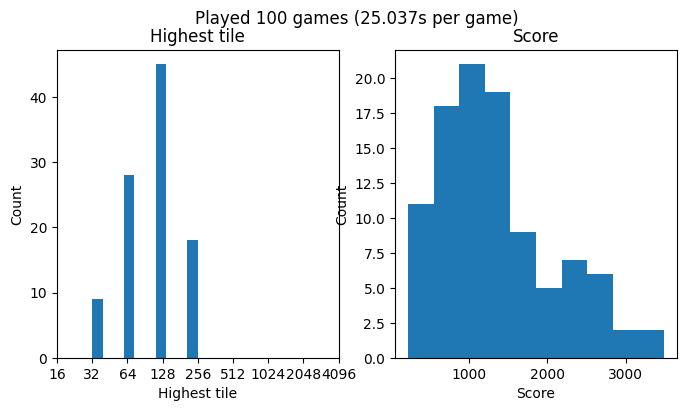

In [ ]:
def policy(state: State) -> Action:
    actions = agent.get_qv(state=state, depth=0, sample_size=[10])
    return max(actions, key=actions.get)
stats(n=100, policy=policy)

### 4 Training the agent

In [ ]:
agent = Agent(env=env, gamma=0.99, learning_rate=0.01, epsilon=0, epsilon_decay=0, epsilon_min=0)

In [ ]:
# Live plotting the training progress
%matplotlib widget
plt.ion()  # Interaktiver Modus an
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(11,8))

ax1 = axes[0,0]
ax1.set_xlabel("Episode")
ax1.set_ylabel("Score")
ax1.set_title("Average score over the last 50 episodes")
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
p1 = ax1.plot([], label="Scores")

ax2 = axes[0,1]
ax2.set_title("Loss")
ax2.set_xlabel("Episode")
ax2.set_ylabel("MSE")
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
p2 = ax2.plot([])


ax3 = axes[1,0]
ax3.set_title("Tile distribution")
ax3.set_xlabel("Episode")
ax3.set_ylabel("%")
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

ax4 = axes[1,1]
ax4.set_title("New states")
ax4.set_ylabel("count")
ax4.set_xlabel("episode")
ax4.set_yscale("log")
p4 = ax4.plot([])

fig.tight_layout()

def update_plot(agent:Agent, tiles: bool = False):
    scores = agent.scores
    if len(agent.losses) > 0 and max(agent.losses) > 0:
        ax2.set_yscale("log")
        p2[0].set_data(list(agent.losses.keys()), list(agent.losses.values()))
    else:
        ax2.set_yscale("linear")
        p2[0].set_data([], [])

    if len(agent.unvisited_states_count) > 0:
        p4[0].set_data(list(agent.unvisited_states_count.keys()), list(agent.unvisited_states_count.values()))
    else:
        p4[0].set_data([], [])
        
    if len(agent.history) == 0:
        p1[0].set_data([], [])
        ax3.clear()
    else:
        if tiles:
            d = []
            for i in range((len(agent.history) - 1)//100+1):
                highest_tiles = np.array([g.highest_tile for g in agent.history[100*i:100*(i+1)]])
                stack = np.array([np.count_nonzero(highest_tiles == 2**i) for i in range(3,14)])
                d.append(stack)
            d = np.array(d)
            d = d.T
            ax3.clear()
            if len(d) > 0:
                ax3.stackplot([100*i for i in range(d.shape[1])], d, labels=[f"{2**i}" for i in range(3,14)], colors=cm.Paired.colors)
                ax3.legend()

        p1[0].set_data(range(1,1+len(m := [np.mean(scores[max(0,i-50):i]) for i in range(1,len(scores)+1)])), m)
        
    for ax in axes.flatten():
        ax.relim()
        ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()

update_plot(agent, tiles=True)

In [ ]:
episode_cap = 100_000
warm_start = False
torch.set_grad_enabled(True)
try:
    for episode in range(agent.episode, episode_cap):
        agent.reset(warm_start=warm_start)
        while env.game.alive:
            done = agent.step()
        agent.remember()
        agent.update()
        agent.decay_epsilon()

        s = f"Episode {episode+1:>4}/{episode_cap}"
        for v in [
            f"Score: {env.game.score:5}", 
            f"Highest tile: {env.game.highest_tile:4}",
            f"Length: {env.game.move_count:3}",
            f"Epsilon: {agent.epsilon:1.3f}",
            f"Average rolling score: {np.mean(agent.scores[max(0,episode-50):]):10.3f}",
            f"Loss: {agent.loss:7.5f}" if agent.loss is not None else "",
            f"V: [{agent.V_range[0][0]:7.1f}, {agent.V_range[0][1]:7.1f}]" if agent.V_range is not None else "",
        ]:
            s += f" - {v}"
        print(s)

        if episode % 10 == 0:
            update_plot(agent, tiles=(episode%25 == 0))
        agent.episode = episode
    agent.episode += 1

except KeyboardInterrupt:
    pass
update_plot(agent)